# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
from scipy.stats import norm

# Functions

In [2]:
def rbe_wedenberg(dose, let, abx,q):
    """
    Wedenberg proton RBE model
    input parameters may be either numpy.array or scalars
    TODO: handle Cube() class directly
    :params dose: physical proton dose in [Gy]
    :params let: LETd in [keV/um] (protons only)
    :params abx: alpha_x / beta_x [Gy]
    :returns: RBE for the given parameters
    :ref: http://dx.doi.org/10.3109/0284186X.2012.705892
    """

    _apx = 1.000 + q * let / abx
    _sbpx = 1.0

    rbe = _rbe_apx(dose, _apx, _sbpx, abx)
    return rbe

In [3]:
def _rbe_apx(dose, apx, sbpx, abx, dzero=0.0):
    """
    :params dose: proton dose      [Gy]
    :params apx: alpha_p / alpha_x [dimensionless] RBE_max = ap/ax when (dose -> 0 Gy)
    :params sbpx: beta_p / beta_x  [dimensionless] RBE_min = sqrt(bp/bx) when (dose -> inf Gy)
    :params abx: alpha_x / beta_x  [Gy]
    :params dzero: what to return in case of dose is zero (which would cause division by zero)
    """

    _rbe = 1.0 / (2.0 * dose)
    if hasattr(_rbe, '__iter__'):
        _rbe[_rbe == np.inf] = dzero
    else:
        if _rbe == np.inf:
            return dzero
    delta = abx * abx + 4. * abx * apx * dose + 4. * sbpx * sbpx * dose * dose
    delta *= (delta > 0)
    _rbe *= (np.sqrt(delta) - abx)
    return _rbe

In [4]:
style_param = {'legend.fontsize': '20',
         'xtick.direction' : 'in',  
         'ytick.direction' : 'in', 
         'xtick.top' : True, 
         'figure.figsize': (10,6),
         'axes.labelsize': '28',
         'axes.titlesize':'28',
         'xtick.labelsize':'24',
         'ytick.labelsize':'24',
         'xtick.major.pad':'22',
         'ytick.major.pad':'22'}
    
pylab.rcParams.update(style_param)

# Open data

In [5]:
open_fname = os.path.join('tmp','distrib_q.h5')
q = pd.read_hdf(open_fname, 'data_1')

In [6]:
fname = os.path.join('data','sobp_shieldhit','output')
dose = os.path.join(fname,'dose.dat')
let=os.path.join(fname,'dlet.dat')

In [7]:
dozym = os.path.join('data','sobp_dosimetry','doz_sobp.xlsx')
df_dozim = pd.read_excel(dozym,names=['depth','dose','depth2','dose2'])

In [8]:
df_dose=pd.read_table(dose,names=['z','dose','err'],sep='\s+')
df_let=pd.read_table(let,names=['z','let','err'],sep='\s+')

In [9]:
# LET and normalized dose in water phantom
dose_max=df_dose.dose[df_dose.dose>0.95*df_dose.dose.max()].mean()
rbe= pd.DataFrame(dtype='float')

#normalize dose to 2[Gy]
rbe["dose"]=df_dose['dose']*2/dose_max
rbe["let"]=df_let['let']
rbe["z"]=df_dose['z']

In [10]:
#z regresji liniowej - notatniki 02a i 02b
mean_W, std_W = 0.434, 0.0301
mean_WA, std_WA = 0.389, 0.0218

In [11]:
q_WA = np.random.normal(loc=mean_WA,scale=std_WA,size=50000)
q_W = np.random.normal(loc=mean_W,scale=std_W,size=50000)

In [12]:
limit=df_dose.z[df_dose.dose<=df_dose.dose.max()*0.01].iloc[0]

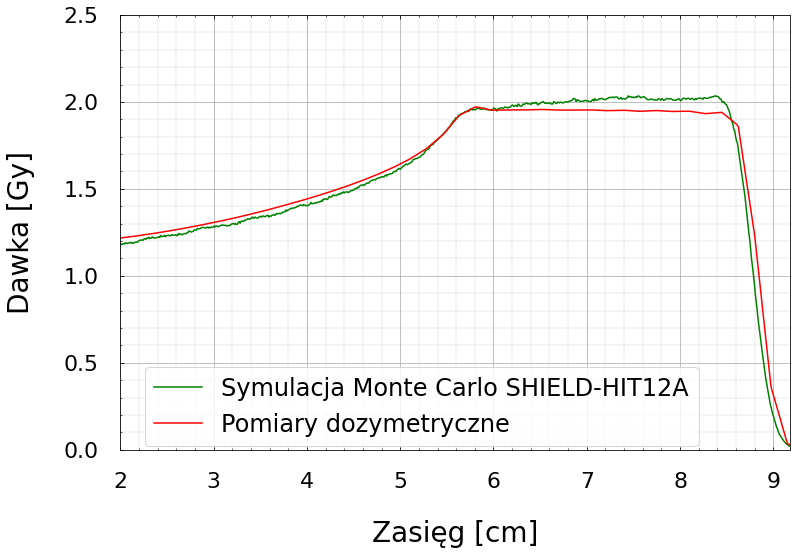

In [13]:
fig,ax = plt.subplots(figsize=[12, 8])

ax.set_xlabel("Zasięg [cm]",size=28, labelpad = 28)
ax.set_ylabel("Dawka [Gy]",size=28, labelpad = 28)

ax.plot(rbe.z, rbe.dose,'green',markersize=1.2, label = "Symulacja Monte Carlo SHIELD-HIT12A")
ax.plot(df_dozim.depth2,df_dozim.dose2,'red',markersize=1.2, label = "Pomiary dozymetryczne")

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_xlim(2,limit)
ax.set_ylim(0,2.5)

ax.legend(loc="center",bbox_to_anchor=(0.45, 0.1), borderaxespad=0.,fontsize=24)

In [14]:
d_mean_dozim = df_dozim.dose2[(df_dozim.depth2>=5.5)&(df_dozim.depth2<=8.5)].mean()

In [15]:
df_dozim.depth2[(df_dozim.depth2 >8.5) & (df_dozim.dose2<= 0.8*d_mean_dozim)].min()

8.711351

In [16]:
d_mean = rbe.dose[(rbe.z>=5.5)&(rbe.z<=8.5)].mean()

In [17]:
rbe.z[(rbe.z>8.5)&(rbe.dose<=d_mean*0.8)].min()

8.665

In [18]:
rbe.z[(rbe.z>8.5)&(rbe.dose<=d_mean*0.8)].min()-df_dozim.depth2[(df_dozim.depth2 >8.5) & (df_dozim.dose2<= 0.8*d_mean_dozim)].min()

-0.04635100000000136

In [19]:
(rbe.z[(rbe.z>8.5)&(rbe.dose<=d_mean*0.8)].min()-df_dozim.depth2[(df_dozim.depth2 >8.5) & (df_dozim.dose2<= 0.8*d_mean_dozim)].min())/df_dozim.depth2[(df_dozim.depth2 >8.5) & (df_dozim.dose2<= 0.8*d_mean_dozim)].min()*100

-0.5320759087769665

In [20]:
(d_mean-d_mean_dozim)/d_mean_dozim*100

2.449570046793247

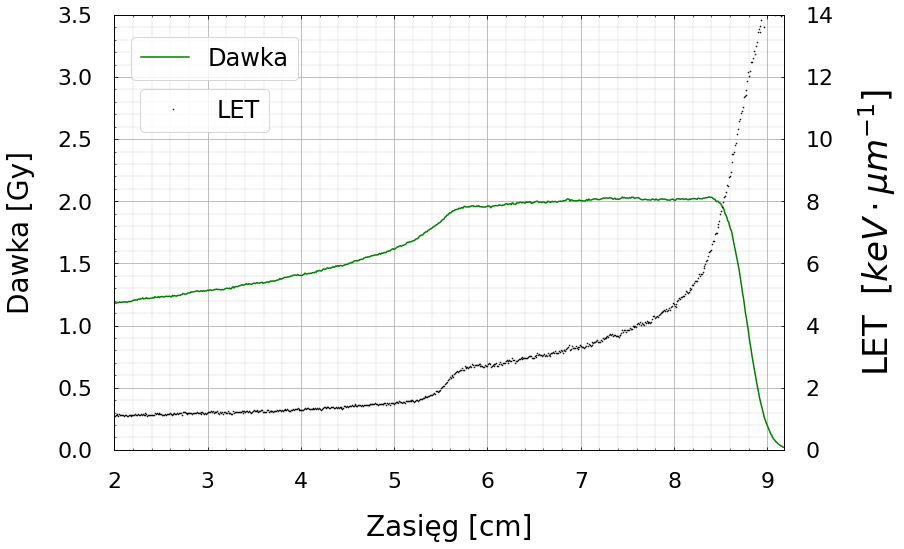

In [21]:
fig,ax = plt.subplots(figsize=[12, 8])

ax2=ax.twinx()
ax.set_xlabel("Zasięg [cm]",size=28, labelpad = 22)
ax.set_ylabel("Dawka [Gy]",size=28, labelpad = 22)
ax2.set_ylabel("LET "+r"$\;[keV \cdot \mu m^{-1}]$",size=34,labelpad = 22,rotation=90)

ax.plot(rbe.z, rbe.dose,'green',markersize=1.2, label = "Dawka")

ax2.plot(rbe.z, rbe.let,'k.',markersize=1.2, label = "LET")


ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major', labelsize=22)
ax2.tick_params(axis='both', which='major', labelsize=22)

#ax.set_title("SHIELDHIT-12A simulation")
ax.set_xlim(2,limit)
ax2.set_xlim(2,limit)
ax.set_ylim(0.,3.5)
ax2.set_ylim(0,14)

ax.legend(loc="center",bbox_to_anchor=(0.15, 0.9), borderaxespad=0.,fontsize=24)
ax2.legend(loc="center",bbox_to_anchor=(0.135, 0.78), borderaxespad=0.,fontsize=24)

In [22]:
#min , max and mean let in SODP
rbe.let[(rbe.z >=5.5) & (rbe.z<=8.5)].min(),rbe.let[(rbe.z >=5.5) & (rbe.z<=8.5)].max(),rbe.let[(rbe.z >=5.5) & (rbe.z<=8.5)].mean()

(1.99726, 7.60289, 3.6758444666666668)

In [23]:
#LET in the center of SOBP 
rbe.let[(rbe.z >=7.)][700]

3.33399

# Wedenberg RBE distribution for LET=2.

In [24]:
abx=10.

In [25]:
tmp_WB = rbe_wedenberg(2.0,3.,abx, q )
tmp_WA = pd.DataFrame(rbe_wedenberg(2.0,3., abx, q_WA))
tmp_W = pd.DataFrame(rbe_wedenberg(2.0,3., abx, q_W))

In [26]:
WA_text = "poszerzony model Wedenberg A \n"+str(np.round(tmp_WA.mean()[0],3))+"+- "+str(np.round(1.44*tmp_WA.std()[0]/tmp_WA.mean()[0]*100,2))+'%'
W_text = "model Wedenberg \n"+str(np.round(tmp_W.mean()[0],3))+"+- "+str(np.round(1.44*tmp_W.std()[0]/tmp_W.mean()[0]*100,2))+'%'
WB_text = "poszerzony model Wedenberg B \n"+str(np.round(tmp_WB.mean()[0],3))+"+- "+str(np.round(1.44*tmp_WB.std()[0]/tmp_WB.mean()[0]*100,2))+'%'

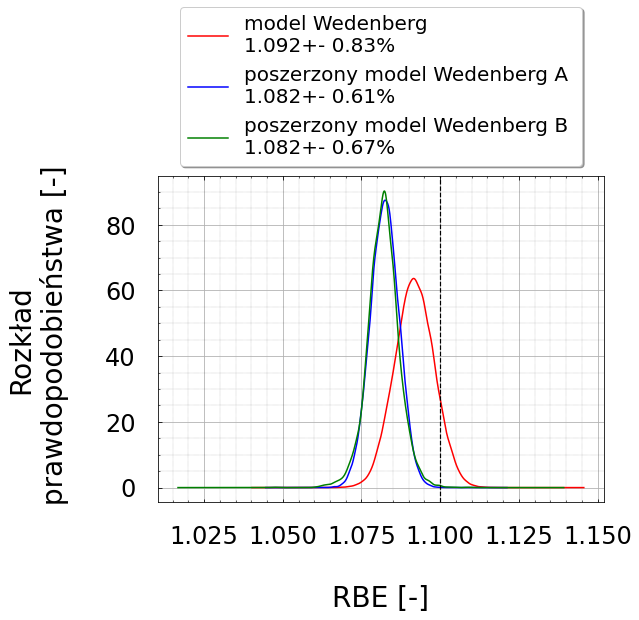

In [27]:
fig,ax = plt.subplots(figsize = (8,6))

tmp_W.plot.kde(ax=ax,color='r')
tmp_WA.plot.kde(ax=ax,color='blue')
tmp_WB.plot.kde(ax=ax,color='green')

ax.axvline(x=1.1, label='RBE = 1.1'.format(1.1),c='k',ls='--',lw=1.2)

ax.set_title("")
ax.set_xlabel("\nRBE [-]")
ax.set_ylabel("Rozkład\n prawdopodobieństwa [-]\n")

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

ax.legend([W_text,WA_text,WB_text],loc='upper center', bbox_to_anchor=(0.5, 1.55),fancybox=True, shadow=True,ncol=1)

In [28]:
#tmp=pd.DataFrame(list(zip(tmp_W,tmp_WA,tmp_WB)),
#                          columns=['rbe'])
#tmp.to_csv("results/figure_5_9")
#fig.savefig(fname="results/figure_5_9.png",dpi= 700)

In [29]:
#RBE for q=0.434 from Wedenberg 85% CI

rbe['wed'] = rbe_wedenberg(rbe.dose, rbe.let, abx, mean_W)
rbe['wed_q_down'] = rbe_wedenberg(rbe.dose, rbe.let, abx, mean_W-1.44*std_W)
rbe['wed_q_up'] = rbe_wedenberg(rbe.dose, rbe.let, abx, mean_W+1.44*std_W)

# our RBE distribution

In [30]:
dfr = (rbe.reset_index(inplace=False))

In [31]:
#optional : n=q.size-1
n=q.size-1

In [32]:
dfr =dfr.append([dfr]*n)

In [33]:
dfr=(dfr.reset_index(inplace=False))[['z','let', 'dose']]

In [34]:
dfr=dfr.sort_values(by=['z', 'let','dose'])

In [35]:
dfr.set_index(['z'],inplace=True) 

In [36]:
for name, group in dfr.groupby('z'):
    dfr.loc[(name), "q"] = q.values[:n+1]

In [37]:
for name, group in dfr.groupby('z'):
    DOSE=group.dose.values
    LET=group.let.values
    Q=group.q.values  
    dfr.loc[(name), "rbe"] = rbe_wedenberg(DOSE, LET, abx, Q)

In [38]:
dfr.reset_index(inplace=True)

In [39]:
dfr_tmp= pd.DataFrame()
dfr_tmp["mediana"]=dfr.groupby('z').rbe.median()
dfr_tmp["meana"]=dfr.groupby('z').rbe.mean()
dfr_tmp["q_down"]=dfr.groupby('z').rbe.quantile(0.075)
dfr_tmp["q_up"]=dfr.groupby('z').rbe.quantile(0.925)

# Biological Dose in SOBP

In [40]:
figure2_df= pd.DataFrame()

In [41]:
figure2_df["Distance_cm"] = rbe.z
figure2_df["Ext_Model_median"] = dfr.groupby('z').rbe.median().values*rbe.dose
figure2_df["Ext_Model_mean"] = dfr.groupby('z').rbe.mean().values*rbe.dose

figure2_df["Wedenberg"] = rbe.wed*rbe.dose
figure2_df["Wedenberg_quantile_down"] = rbe.wed_q_down*rbe.dose
figure2_df["Wedenberg_quantile_up"] = rbe.wed_q_up*rbe.dose

figure2_df["Physical__Dose"] = rbe.dose
figure2_df["Dose_for_RBE_1_1"] = rbe.dose*1.1
figure2_df["Ext_Model_quantile_down"] = dfr.groupby('z').rbe.quantile(0.075).values*rbe.dose
figure2_df["Ext_Model_quantile_up"] = dfr.groupby('z').rbe.quantile(0.925).values*rbe.dose

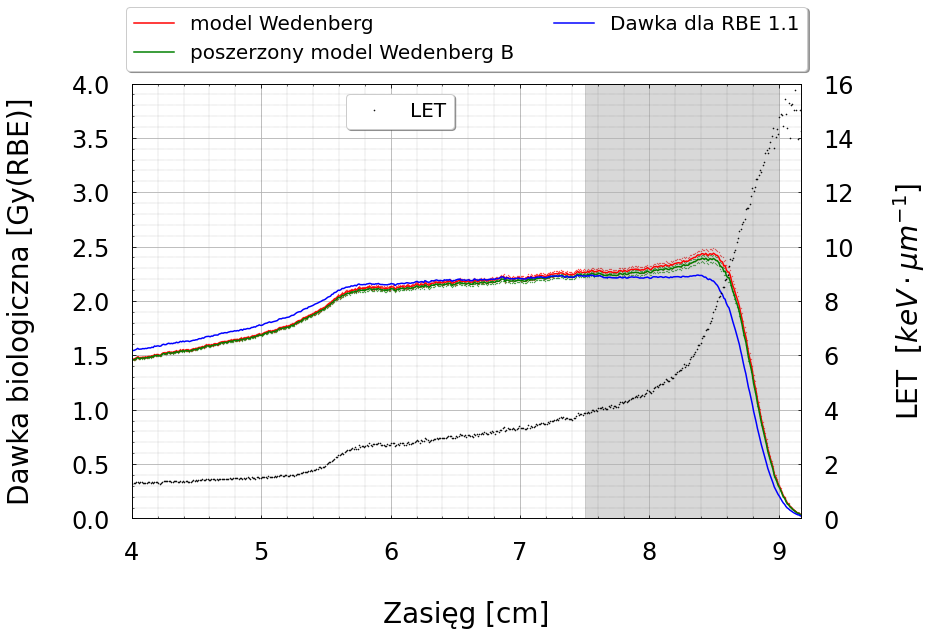

In [42]:
fig,ax = plt.subplots(figsize=[12, 8])

ax2=ax.twinx()
ax.set_xlabel("\nZasięg [cm]")
ax.set_ylabel("Dawka biologiczna [Gy(RBE)]\n")
ax2.set_ylabel("\nLET "+r"$\;[keV \cdot \mu m^{-1}]$",rotation=90)

ax.set_xticks(np.arange(3, limit, 1.0))

ax2.plot(rbe.z, rbe.let,'k.',markersize=1.2, label = "LET")

#ax.plot(rbe.z, rbe.dose,c='k',label="Dose [Gy]")
ax.plot(figure2_df.Distance_cm,figure2_df.Wedenberg,'red', label = "model Wedenberg")
ax.plot(figure2_df.Distance_cm,figure2_df.Ext_Model_mean,'green',markersize=0.2, label= "poszerzony model Wedenberg B")
ax.plot(figure2_df.Distance_cm, figure2_df.Dose_for_RBE_1_1,'blue',markersize=0.1, label = "Dawka dla RBE 1.1") 

ax.scatter(figure2_df.Distance_cm,figure2_df.Ext_Model_quantile_down, s=0.1,c='green')
ax.scatter(figure2_df.Distance_cm,figure2_df.Ext_Model_quantile_up, s=0.1,c='green')

ax.scatter(figure2_df.Distance_cm,figure2_df.Wedenberg_quantile_down,s=0.1,c='red')
ax.scatter(figure2_df.Distance_cm,figure2_df.Wedenberg_quantile_up,s=0.1,c='red')


ax.set_ylim(0,4)
ax2.set_ylim(0,16)

ax.set_xlim(4,limit)
ax2.set_xlim(4,limit)

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major')

ax.axvspan(7.5,9, alpha=0.3, color='gray')

#ax.legend(loc="center",bbox_to_anchor=(0.33, 0.9), borderaxespad=0.,fontsize=20)
#ax2.legend(loc="center",bbox_to_anchor=(0.88, 0.95), borderaxespad=0.,fontsize=20)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),fancybox=True, shadow=True,ncol=2)

ax2.legend(loc='upper center', bbox_to_anchor=(0.4, 1.),fancybox=True, shadow=True,ncol=1)

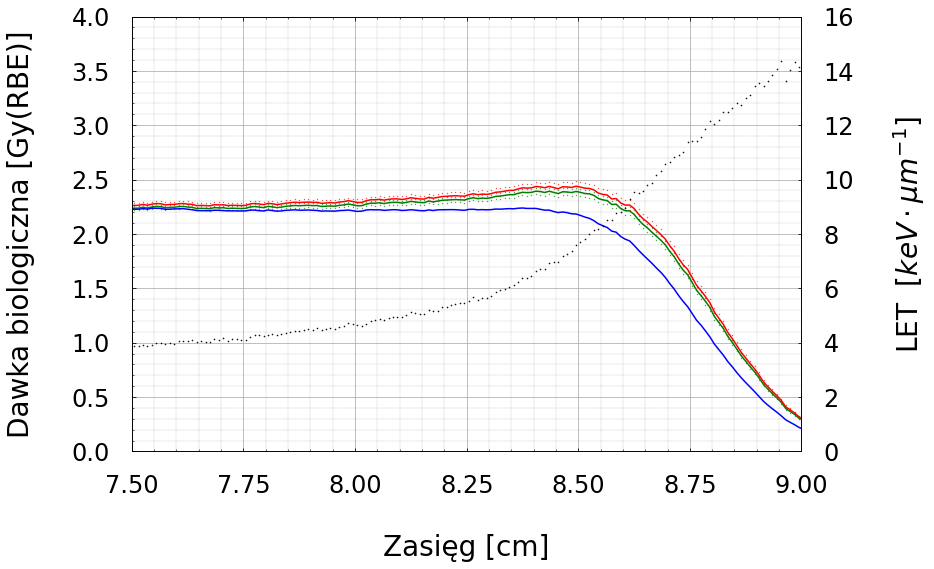

In [43]:
fig,ax = plt.subplots(figsize=[12, 8])

ax2=ax.twinx()
ax.set_xlabel("\nZasięg [cm]")
ax.set_ylabel("Dawka biologiczna [Gy(RBE)]\n")
ax2.set_ylabel("\nLET "+r"$\;[keV \cdot \mu m^{-1}]$",rotation=90)

ax.set_xticks(np.arange(3, limit, 1.0))

ax2.plot(rbe.z, rbe.let,'k.',markersize=1.2, label = "LET")

#ax.plot(rbe.z, rbe.dose,c='k',label="Dose [Gy]")
ax.plot(figure2_df.Distance_cm,figure2_df.Ext_Model_mean,'green',markersize=0.2, label= "Wedenberg extended model B")
ax.plot(figure2_df.Distance_cm,figure2_df.Wedenberg,'red', label = "Wedenberg model")
ax.plot(figure2_df.Distance_cm, figure2_df.Dose_for_RBE_1_1,'blue',markersize=0.1, label = "Dose for RBE 1.1") 

ax.scatter(figure2_df.Distance_cm,figure2_df.Ext_Model_quantile_down, s=0.1,c='green')
ax.scatter(figure2_df.Distance_cm,figure2_df.Ext_Model_quantile_up, s=0.1,c='green')

ax.scatter(figure2_df.Distance_cm,figure2_df.Wedenberg_quantile_down,s=0.1,c='red')
ax.scatter(figure2_df.Distance_cm,figure2_df.Wedenberg_quantile_up,s=0.1,c='red')


ax.set_ylim(0,4)
ax2.set_ylim(0,16)

ax.set_xlim(7.5,9)
ax2.set_xlim(7.5,9)

start, end = ax.get_xlim()
stepsize=0.25
ax.xaxis.set_ticks(np.arange(start, end+stepsize, stepsize))


ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major')

#ax.legend(loc="center",bbox_to_anchor=(0.33, 0.9), borderaxespad=0.,fontsize=20)
#ax2.legend(loc="center",bbox_to_anchor=(0.88, 0.95), borderaxespad=0.,fontsize=20)


In [44]:
#mean doses in SOBP for 3 models
m_dose_W=figure2_df.Wedenberg[(figure2_df.Distance_cm >=5.5) &(figure2_df.Distance_cm <=8.5)].mean()
m_dose_E=figure2_df.Ext_Model_mean[(figure2_df.Distance_cm >=5.5) &(figure2_df.Distance_cm <=8.5)].mean()
m_dose_C=figure2_df.Dose_for_RBE_1_1[(figure2_df.Distance_cm >=5.5) &(figure2_df.Distance_cm <=8.5)].mean()
m_dose_W,  m_dose_E, m_dose_C

(2.218433590530119, 2.1944087090059656, 2.1938169159235477)

In [45]:
#differences in mean doses in SOBP
(m_dose_W-m_dose_C)/m_dose_C *100,(m_dose_E-m_dose_C)/m_dose_C *100,(m_dose_W-m_dose_E)/m_dose_E *100

(1.122093390195617, 0.026975500011988778, 1.0948225563248155)

In [46]:
#mean upper doses in SOBP for Wedenberg and Extended models
up_dose_W=figure2_df.Wedenberg_quantile_up[(figure2_df.Distance_cm >=5.5) &(figure2_df.Distance_cm <=8.5)].mean()
up_dose_E=figure2_df.Ext_Model_quantile_up[(figure2_df.Distance_cm >=5.5) &(figure2_df.Distance_cm <=8.5)].mean()
up_dose_W, up_dose_E

(2.240397139261743, 2.211319875035218)

In [47]:
#mean error in SOBP
(up_dose_W-m_dose_W)/m_dose_W*100, (up_dose_E-m_dose_E)/m_dose_E*100

(0.9900476095106214, 0.7706479636107976)

In [48]:
#range for 3 models
range_W=figure2_df.Distance_cm[(figure2_df.Distance_cm >=8.5) & (figure2_df.Wedenberg <= m_dose_W*0.8)].min()
range_E=figure2_df.Distance_cm[(figure2_df.Distance_cm >=8.5) & (figure2_df.Ext_Model_mean <= m_dose_E*0.8)].min()
range_C=figure2_df.Distance_cm[(figure2_df.Distance_cm >=8.5) & (figure2_df.Dose_for_RBE_1_1 <= m_dose_C*0.8)].min()
range_C, range_W, range_E

(8.665, 8.725, 8.725)

In [49]:
#differences in ranges Extended-Clinical
(range_E-range_C)/range_C*100

0.6924408540103925

In [50]:
#differences in ranges EWedenberg-Clinical
(range_W-range_C)/range_C*100

0.6924408540103925

In [51]:
#differences in ranges Wedenberg-Extended
(range_W-range_E)/range_E*100

0.0

In [52]:
#doses in distal edge of SOBP for range = clinical range
d_dose_W=figure2_df.Wedenberg[figure2_df.Distance_cm ==range_C].values
d_dose_E=figure2_df.Ext_Model_mean[figure2_df.Distance_cm ==range_C].values
d_dose_C=figure2_df.Dose_for_RBE_1_1[figure2_df.Distance_cm ==range_C].values
d_dose_W, d_dose_E, d_dose_C

(array([2.06811196]), array([2.0158862]), array([1.73037464]))

In [53]:
#upper doses in distal edge of SOBP for range = clinical range
up_d_dose_W=figure2_df.Wedenberg_quantile_up[figure2_df.Distance_cm ==range_C].values
up_d_dose_E=figure2_df.Ext_Model_quantile_up[figure2_df.Distance_cm ==range_C].values

In [54]:
#differences in doses in distal SOBP
(d_dose_W-d_dose_C)/d_dose_W*100,(d_dose_E-d_dose_C)/d_dose_W *100,(d_dose_W-d_dose_E)/d_dose_E *100

(array([16.33070781]), array([13.80542097]), array([2.5907097]))

In [55]:
#error in distal SOBP in one point
(up_d_dose_W-d_dose_W)/d_dose_W*100, (up_d_dose_E-d_dose_E)/d_dose_E*100

(array([2.29916037]), array([1.82500996]))

# IN SOBP

In [56]:
def dose_in_sobp(range_insobp, title, lim1,lim2):
    fig,ax = plt.subplots(figsize = (10,6))

    df_W = pd.DataFrame(rbe_wedenberg(np.float64(rbe[rbe.z==range_insobp].dose.values), 
                        rbe[rbe.z == range_insobp].let.values, 
                        abx, q_W)*rbe[rbe.z == range_insobp].dose.values)
    
    df_W.plot.kde(ax=ax,color='red')
        
    df_WA = pd.DataFrame(rbe_wedenberg(np.float64(rbe[rbe.z==range_insobp].dose.values), 
                        rbe[rbe.z == range_insobp].let.values, 
                        abx, q_WA)*rbe[rbe.z == range_insobp].dose.values)
    
    df_WA.plot.kde(ax=ax,color='blue')

    df_WB = rbe_wedenberg(np.float64(rbe[rbe.z==range_insobp].dose.values), 
                        rbe[rbe.z == range_insobp].let.values, 
                        abx, q.q)*rbe[rbe.z == range_insobp].dose.values
    
    df_WB.plot.kde(ax=ax,color='green')
   
    #ax.axvline(figure2_df[figure2_df.Distance_cm == range_insobp].Dose_for_RBE_1_1.values, c='black',ls='-.')

    
    W_text =   "model Wedenberg\n" +str(np.round(df_W.mean()[0],3)) + "+-" + str(np.round(1.44*df_W.std()[0],3)) +"(" +  str(np.round(1.44*df_W.std()[0]/df_W.mean()[0]*100,2)) + "%)"
    WA_text =   "poszerzony model Wedenberg A\n" +str(np.round(df_WA.mean()[0],3)) + "+-" + str(np.round(1.44*df_WA.std()[0],3)) +"(" +  str(np.round(1.44*df_WA.std()[0]/df_WA.mean()[0]*100,2)) + "%)"
    #WB_text =   "poszerzony model Wedenber B\n" +str(np.round(df_WB.mean()[0],3)) + "+-" + str(np.round(1.44*df_WB.std()[0],3)) +"(" +  str(np.round(1.44*df_WB.std()[0]/df_WB.mean()[0]*100,2)) + "%)"

    
    Clinic = "Dawka dla RBE = 1.1"
    
    print((df_W.mean()-df_WB.mean())/df_W.mean()*100)
    print((df_WB.mean()-figure2_df[figure2_df.Distance_cm == range_insobp].Dose_for_RBE_1_1.values)/df_WB.mean()*100)
    print((df_W.mean()-figure2_df[figure2_df.Distance_cm == range_insobp].Dose_for_RBE_1_1.values)/df_W.mean()*100)

    ax.set_xlabel("\nDawka biologiczna [Gy(RBE)]")
    ax.set_ylabel("Rozkład \nprawdopodobieństwa\n"+r"$[Gy(RBE)^{-1}]$")
    ax.set_title(title)
    ax.grid()
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
    ax.set_xlim(lim1,lim2)
    
    ax.set_ylim(0,None)
    ax.legend([W_text,WA_text,WB_text, Clinic],loc='upper center', bbox_to_anchor=(1, 1),fancybox=True, shadow=True,ncol=1)

In [57]:
plateau = 2.005
middle = 7.005
distal = 8.665

0    0.401926
dtype: float64
[-6.35611619]
0   -5.928644
dtype: float64


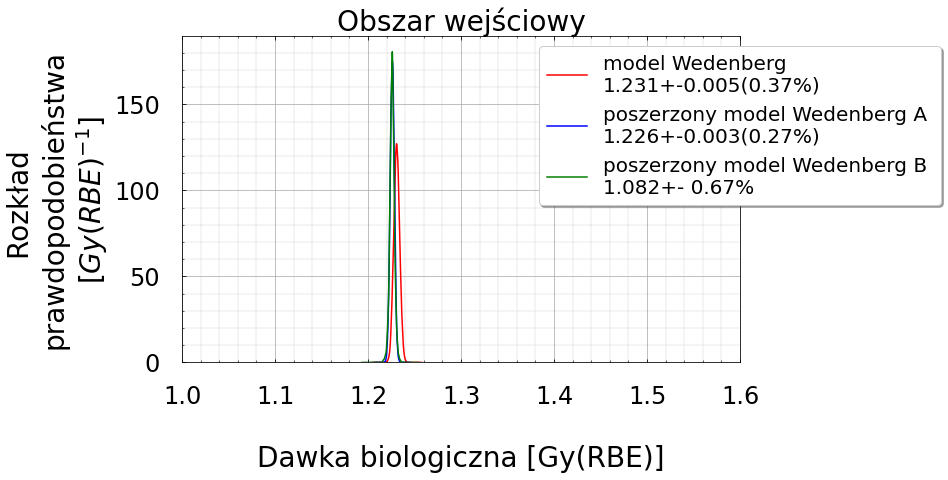

In [58]:
dose_in_sobp(plateau, "Obszar wejściowy",1.,1.6)

0    0.994048
dtype: float64
[-0.83613042]
0    0.166229
dtype: float64


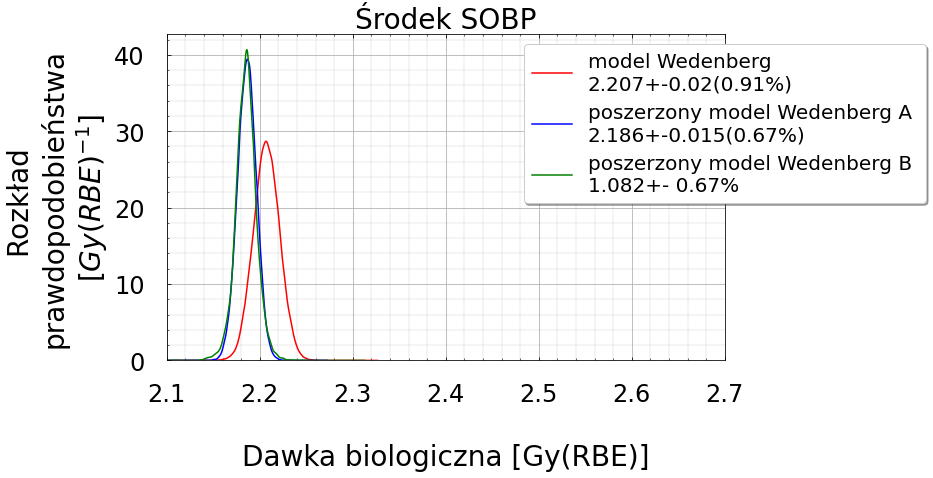

In [59]:
dose_in_sobp(middle, "Środek SOBP",2.1,2.7)

0    2.525051
dtype: float64
[14.16307935]
0    16.330505
dtype: float64


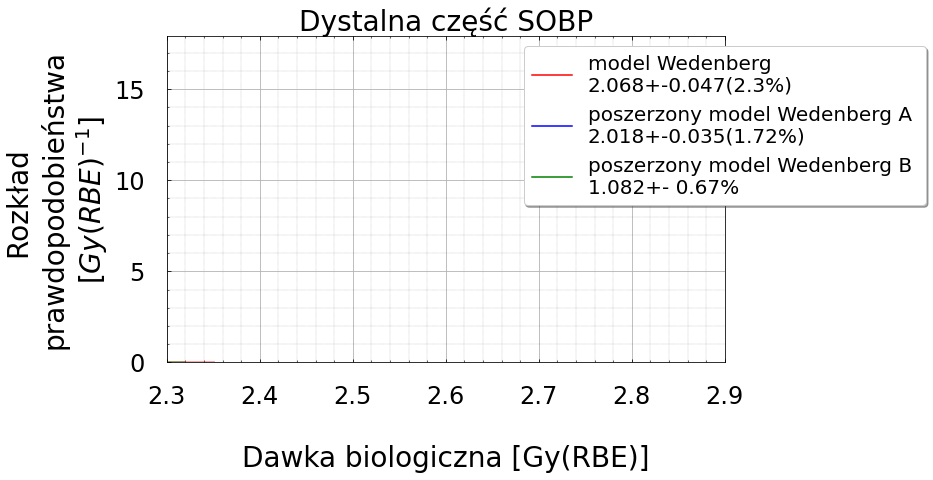

In [60]:
dose_in_sobp(distal, "Dystalna część SOBP",2.3,2.9)

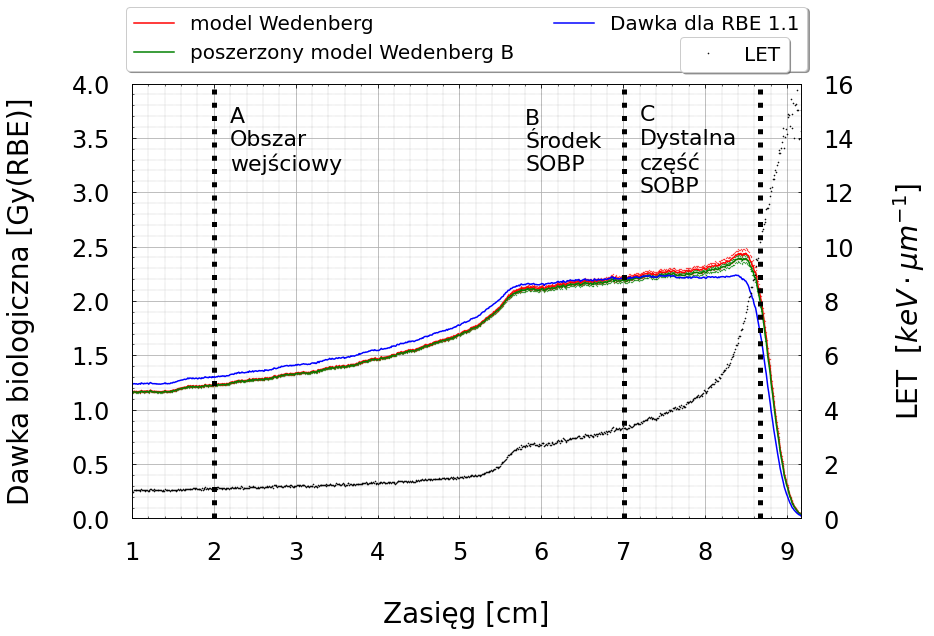

In [61]:
fig,ax = plt.subplots(figsize=[12, 8])

ax2=ax.twinx()
ax.set_xlabel("\nZasięg [cm]")
ax.set_ylabel("Dawka biologiczna [Gy(RBE)]\n")
ax2.set_ylabel("\nLET "+r"$\;[keV \cdot \mu m^{-1}]$",rotation=90)

ax.set_xticks(np.arange(1, limit, 1.0))

ax2.plot(rbe.z, rbe.let,'k.',markersize=1.2, label = "LET")

#ax.plot(rbe.z, rbe.dose,c='k',label="Dose [Gy]")
ax.plot(figure2_df.Distance_cm,figure2_df.Wedenberg,'red', label = "model Wedenberg")

ax.plot(figure2_df.Distance_cm,figure2_df.Ext_Model_mean,'green',markersize=0.2, label= "poszerzony model Wedenberg B")
ax.plot(figure2_df.Distance_cm, figure2_df.Dose_for_RBE_1_1,'blue',markersize=0.1, label = "Dawka dla RBE 1.1") 

ax.scatter(figure2_df.Distance_cm,figure2_df.Ext_Model_quantile_down, s=0.1,c='green')
ax.scatter(figure2_df.Distance_cm,figure2_df.Ext_Model_quantile_up, s=0.1,c='green')

ax.scatter(figure2_df.Distance_cm,figure2_df.Wedenberg_quantile_down,s=0.1,c='red')
ax.scatter(figure2_df.Distance_cm,figure2_df.Wedenberg_quantile_up,s=0.1,c='red')


ax.set_ylim(0,4)
ax2.set_ylim(0,16)

ax.set_xlim(1,limit)
ax2.set_xlim(1,limit)

ax.grid()
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='k')
ax.tick_params(axis='both', which='major')

ax.axvline(plateau,  color='black',ls=':', lw=5)
ax.text(2.2, 3.2, 'A\nObszar\nwejściowy',fontsize=22)

ax.axvline(middle,  color='black',ls=':', lw=5)
ax.text(5.8, 3.2, 'B\nŚrodek\nSOBP',fontsize=22)


ax.axvline(distal,  color='black',ls=':', lw=5)
ax.text(7.2, 3., 'C\nDystalna\nczęść\nSOBP',fontsize=22)

#ax.legend(loc="center",bbox_to_anchor=(0.33, 0.9), borderaxespad=0.,fontsize=20)
#ax2.legend(loc="center",bbox_to_anchor=(0.88, 0.95), borderaxespad=0.,fontsize=20)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),fancybox=True, shadow=True,ncol=2)

ax2.legend(loc='upper center', bbox_to_anchor=(0.9, 1.13),fancybox=True, shadow=True,ncol=1)